In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import image_loader
import torch
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from tqdm import tqdm
import numpy as np

import copy

csv_file = '../data/movie_data2.csv'
img_dir = '../data/MoviePosters'

In [3]:
# Parameters?

useTransforms = False
numEpochs = 20
genres = ['Comedy']

In [4]:
transformVar = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p = 0.25),
    transforms.RandomVerticalFlip(p = 0.25),
    transforms.RandomRotation(60)
])

if not useTransforms:
    transformVar = None

In [5]:
pod = image_loader.PosterDataset(csv_file, img_dir, transform = transformVar, genres = genres)

In [6]:
len(pod)

11299

In [7]:
# just a test to see if transformations work

# save_image(pod.__getitem__(0)[0] / 255, 'test.png')

In [8]:
from torch.utils.data import DataLoader

trainSize = int(len(pod) * 0.9)
testSize = len(pod) - trainSize

trainData, testData = torch.utils.data.random_split(pod, [trainSize, testSize])
def batch_function(raw_output):
    xs, ys = zip(*raw_output)
    batchxs = torch.nn.utils.rnn.pad_sequence(xs, batch_first=True)
    batchys = torch.Tensor(ys)
    return batchxs, batchys

BATCH_SIZE = 5
trainDataLoader = DataLoader(trainData, batch_size = BATCH_SIZE, shuffle=True, collate_fn=batch_function)
testDataLoader = DataLoader(testData, batch_size = 1, shuffle=True)

In [9]:
xs, ys = next(iter(trainDataLoader))
xs[0].shape

C:\Users\terre\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 256, 256])

In [10]:
len(trainData)

10169

In [11]:
# download VGG19 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg19_bn(pretrained=True, progress=True).features.to(device).eval()

C:\Users\terre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\terre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
print(device)

cuda


In [13]:
# Initialize the model
# num_features = model.features[-1].out_channels  # Get the number of output channels of the last convolutional layer
# model.features.add_module('7', nn.Conv2d(num_features, 1, 1))  # Add a 1x1 convolutional layer to change the output size to 1
model = model.to(device)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
class MoviePredictor(torch.nn.Module):
    def __init__(self, vggmodel, linear_params):
        super().__init__()
        self.vggmodel = vggmodel
        self.predictor_1 = torch.nn.Linear(512 * 8 * 8, linear_params)
        self.out = torch.nn.Linear(linear_params, 1)
    def forward(self, input: torch.Tensor):
        vgg_out = self.vggmodel(input).reshape(input.shape[0], 512 * 8 * 8)
        output = self.out(self.predictor_1(vgg_out))
        return output

In [15]:
predictor_model = MoviePredictor(model, linear_params= 512).to(device)

In [16]:
predictor_model(pod[1][0][None,:,:,:].to(device))

tensor([[0.0046]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [17]:
trainLossPlt = []
testLossPlt = []

In [18]:
# Train the model
def train_model(in_model, criterion, optimizer, num_epochs):
    # uses global training data
    print(f"Training for {num_epochs} epoch(s).")
    
    for epoch in range(num_epochs):
        in_model.train()
        running_loss = 0.0
        pbar = tqdm(trainDataLoader)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = in_model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            if np.isnan(loss.item()).any():
                print("NaN encountered in calculating loss, aborting")
                print(f"Predictions: {outputs}")
                print(f"Labels: {labels}")
                return

            running_loss += loss.item()
            pbar.set_description(f"Loss: {loss.item():.6f}")
        trainLossPlt.append(running_loss/len(trainDataLoader))
        print(f'Epoch {epoch+1}, Average Loss: {running_loss/len(trainDataLoader):.6f}')

        # Test the model
        print("Testing Model")
        in_model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(testDataLoader):
                images, labels = images.to(device), labels.to(device)
                outputs = in_model(images)
                loss = criterion(outputs.squeeze(), labels.float().squeeze())
                test_loss += loss.item()
        testLossPlt.append(test_loss/len(testDataLoader))
        print(f'Test Loss: {test_loss/len(testDataLoader)}')

In [19]:
class DeepDropPredictor(nn.Module):
    def __init__(self, vggmodel, dropout_p, num_extra_lin, hidden_dim):
        super().__init__()
        self.vgg_model = vggmodel
        self.flattened = nn.Linear(512 * 8 * 8, hidden_dim)
        self.lin_layers = nn.ParameterList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_extra_lin)])
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p=dropout_p)
    def forward(self, input: torch.Tensor):
        output = self.dropout(self.vgg_model(input).reshape(input.shape[0], 512 * 8 * 8))
        output = self.dropout(self.flattened(output))
        for layer in self.lin_layers:
            output = self.dropout(layer(output))
        output = self.out(output)
        return output

In [20]:
def test_model(in_model, criterion):
    in_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(testDataLoader):
            images, labels = images.to(device), labels.to(device)
            outputs = in_model(images)
            loss = criterion(outputs.squeeze(), labels.float().squeeze())
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(testDataLoader)}')

def test_empty_model(in_model, criterion):
    # in_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(testDataLoader):
            images, labels = images.to(device), labels.to(device)
            outputs = in_model(images)
            loss = criterion(outputs.squeeze(), labels.float().squeeze())
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(testDataLoader)}')
    
    return test_loss/len(testDataLoader)

In [21]:
deepDropPredictor = DeepDropPredictor(model, 0.5, 2, 512).to(device)
deepDropPredictor.vgg_model.requires_grad_(False)
deepOptim = optim.Adam(deepDropPredictor.parameters(), lr=1e-5)
loss_fn = nn.MSELoss(reduction="mean")

In [22]:
train_model(deepDropPredictor, loss_fn, deepOptim, numEpochs)

Training for 20 epoch(s).


Loss: 3.930334: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:33<00:00, 21.70it/s]


Epoch 1, Average Loss: 3.398490
Testing Model


100%|█████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 100.01it/s]


Test Loss: 1.620839699976011


Loss: 6.605449: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:33<00:00, 21.73it/s]


Epoch 2, Average Loss: 1.952207
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 99.59it/s]


Test Loss: 1.3744417048572777


Loss: 0.868291: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:33<00:00, 21.73it/s]


Epoch 3, Average Loss: 1.762296
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 94.19it/s]


Test Loss: 1.3862187365537315


Loss: 1.444435: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:31<00:00, 22.15it/s]


Epoch 4, Average Loss: 1.731491
Testing Model


100%|█████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 100.38it/s]


Test Loss: 1.3893966982394157


Loss: 1.137562: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:31<00:00, 22.15it/s]


Epoch 5, Average Loss: 1.624538
Testing Model


100%|█████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 100.28it/s]


Test Loss: 1.3419009758466889


Loss: 0.365609: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:31<00:00, 22.15it/s]


Epoch 6, Average Loss: 1.553357
Testing Model


100%|█████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 100.75it/s]


Test Loss: 1.444260831295056


Loss: 3.788179: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:31<00:00, 22.16it/s]


Epoch 7, Average Loss: 1.529685
Testing Model


100%|█████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 100.38it/s]


Test Loss: 1.3563709479591688


Loss: 0.854328: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:31<00:00, 22.15it/s]


Epoch 8, Average Loss: 1.491162
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 99.68it/s]


Test Loss: 1.436389270588974


Loss: 3.108749: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:31<00:00, 22.11it/s]


Epoch 9, Average Loss: 1.486737
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 95.62it/s]


Test Loss: 1.4626194721663772


Loss: 2.513700: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:32<00:00, 21.88it/s]


Epoch 10, Average Loss: 1.503643
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 96.98it/s]


Test Loss: 1.4635011101276647


Loss: 2.242087: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:34<00:00, 21.48it/s]


Epoch 11, Average Loss: 1.460068
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 97.74it/s]


Test Loss: 1.4625224002388677


Loss: 1.358923: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:35<00:00, 21.40it/s]


Epoch 12, Average Loss: 1.440452
Testing Model


100%|█████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 100.60it/s]


Test Loss: 1.4305559260227012


Loss: 2.283827: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:32<00:00, 21.88it/s]


Epoch 13, Average Loss: 1.416577
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 96.69it/s]


Test Loss: 1.4021879398388521


Loss: 1.672342: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:36<00:00, 21.16it/s]


Epoch 14, Average Loss: 1.386332
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 96.87it/s]


Test Loss: 1.3701261091254302


Loss: 0.783309: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:34<00:00, 21.61it/s]


Epoch 15, Average Loss: 1.387951
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:12<00:00, 92.62it/s]


Test Loss: 1.7176986680116446


Loss: 0.772102: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:35<00:00, 21.28it/s]


Epoch 16, Average Loss: 1.352916
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 97.41it/s]


Test Loss: 1.4856058459370431


Loss: 0.615339: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:34<00:00, 21.60it/s]


Epoch 17, Average Loss: 1.352794
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 96.65it/s]


Test Loss: 1.33682500730481


Loss: 0.432686: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:35<00:00, 21.26it/s]


Epoch 18, Average Loss: 1.330513
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:11<00:00, 95.24it/s]


Test Loss: 1.4056590135443043


Loss: 0.255491: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:38<00:00, 20.72it/s]


Epoch 19, Average Loss: 1.345737
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:12<00:00, 90.25it/s]


Test Loss: 1.4071853124933897


Loss: 1.434434: 100%|██████████████████████████████████████████████████████████████| 2034/2034 [01:41<00:00, 20.11it/s]


Epoch 20, Average Loss: 1.294197
Testing Model


100%|██████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:12<00:00, 91.04it/s]

Test Loss: 1.3372428124039812


In [23]:
baselineLoss = test_empty_model(lambda x: torch.Tensor([6.413]).to(device), loss_fn) # average score

100%|█████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:01<00:00, 586.27it/s]

Test Loss: 1.244432933110923


In [24]:
torch.save(deepDropPredictor.state_dict(), "../models/DeepDrop3-512_horror.pt")

In [25]:
torch.save(trainData, "../datasets/traindata.dataset_horror")
torch.save(testData, "../datasets/testdata.dataset_horror")

In [26]:
total_params = 0
for param in list(deepDropPredictor.parameters())[-8:]:
    print(param.size().numel())
    total_params += param.size().numel()
print(f"{total_params:,}")

16777216
512
262144
512
262144
512
512
1
17,303,553


1.244432933110923


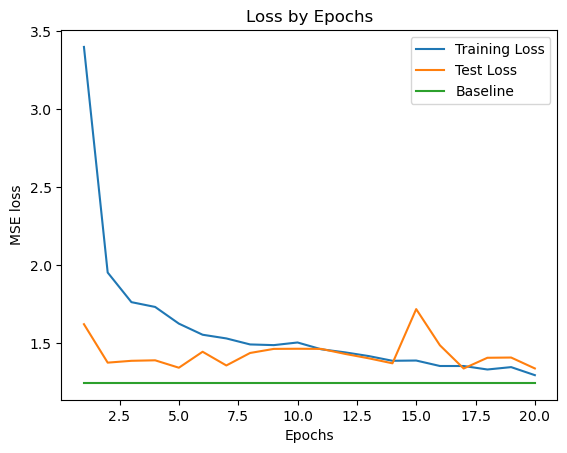

In [27]:
baseLossPlt = [baselineLoss] * numEpochs

print(baselineLoss)

yLst = list(range(1,21))

plt.plot(yLst, trainLossPlt)
plt.plot(yLst, testLossPlt)
plt.plot(yLst, baseLossPlt)

plt.title("Loss by Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend(["Training Loss", "Test Loss", "Baseline"])

plt.show()